<a href="https://colab.research.google.com/github/lsmanoel/BasicOfPython/blob/master/PythonFinance/AlphaVantageAPI_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha Vantage Stock Data API

[alphavantage.co](https://www.alphavantage.co/)

API key: LAFE0OQUFL56YEPA (Free Account)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class StockList:
  #-----------------------------------------------------------------------------
  def __init__(self, stock_list=None, data_period_type='TIME_SERIES_DAILY_ADJUSTED'):
    self.stock_list_N = 0
    self.data_period_type = data_period_type
    self.stock_list = []
    self.stock_data_list=[]
    
    if stock_list == None: pass
    else: self.append_StockDataList(stock_list)

  #-----------------------------------------------------------------------------
  def get_StockData(self, stock_symbol):
    stock_index = [stock_index for stock_index, stock in enumerate(self.stock_list) if stock[0] == stock_symbol]  
    if stock_index==[]: print("stock symbol not found!") 
    else: return self.stock_data_list[stock_index[0]]
  
  #-----------------------------------------------------------------------------
  def append_StockData(self, stock):
    self.stock_list_N += 1
    self.stock_list.append(stock)
    stock_symbol = stock[0]
    stock_name = stock[1]
    url='https://www.alphavantage.co/query?function='+self.data_period_type+'&symbol='+stock_symbol+'&apikey=LAFE0OQUFL56YEPA&datatype=csv' 
    self.stock_data_list.append(pd.read_csv(url))
    print(self.stock_list_N, stock_symbol, stock_name, self.stock_data_list[-1].shape)

  #-----------------------------------------------------------------------------
  def remove_StockData(self, stock_symbol):
    stock_index=[stock_index for stock_index, stock in enumerate(self.stock_list) if stock[0] == stock_symbol]  
    if stock_index==[]: print("stock symbol not found!")
    else:
      stock_index=stock_index[0]
      print("index:",stock_index, stock_symbol, "Removed!")
      del self.stock_list[stock_index]
      del self.stock_data_list[stock_index]
      self.stock_list_N -= 1

  #-----------------------------------------------------------------------------
  def append_StockDataList(self, stock_list):
    if len(stock_list)>5:
      print("Len:", len(stock_list), " -> List is too big... Appends only 5 stocks at a time of 1 minute!")
    else:
      for stock in stock_list:
        self.append_StockData(stock)
    
  #-----------------------------------------------------------------------------
  def get_StockPhaseTable(self, stock_phase='close'):
    if stock_phase in ('open', 'close', 'high', 'low', 'volume'):
      stock_phase_table = pd.DataFrame()
      for i, stock_data in enumerate(self.stock_data_list):
        stock_data_temp = stock_data[stock_phase]
        stock_phase_table = pd.concat([stock_phase_table, 
                                       stock_data_temp.rename(self.stock_list[i][0])], 
                                      axis=1)
      return stock_phase_table
    
    elif stock_phase == 'mean2':
      stock_phase_table = pd.DataFrame()
      for i, stock_data in enumerate(self.stock_data_list):
        stock_data_temp = (stock_data['open']+stock_data['close'])/2
        stock_phase_table = pd.concat([stock_phase_table, 
                                       stock_data_temp.rename(self.stock_list[i][0])], 
                                      axis=1)
      return stock_phase_table
    
    elif stock_phase == 'mean4':
      stock_phase_table = pd.DataFrame()
      for i, stock_data in enumerate(self.stock_data_list):
        stock_data_temp = (stock_data['open']+stock_data['close']+stock_data['high']+stock_data['low'])/4
        stock_phase_table = pd.concat([stock_phase_table, 
                                       stock_data_temp.rename(self.stock_list[i][0])], 
                                      axis=1)
      return stock_phase_table
    
    else: 
      print("invalid stock phase!")

    

      
  #-----------------------------------------------------------------------------  
  def correlation_StockPhaseTable(self, stock_phase='close'):    
    return self.get_StockPhaseTable(stock_phase).corr()
    
  #=============================================================================
  #Plotters Method:
  #-----------------------------------------------------------------------------
  def plot_candles_allStocksData(self, plot_size=30):
    for i, stock_data in enumerate(self.stock_data_list):
      cols = list(stock_data.columns.values)
      data_plot_format = stock_data[[cols[0], cols[1], cols[4], cols[2], cols[3], cols[6]]]
      
      self.plot_candles(data_plot_format[:plot_size], 
                   self.data_period_type, 
                   title = self.stock_list[i][0], 
                   volume_bars=True)

  #-----------------------------------------------------------------------------
  def plot_candles_StockData(self, stock_symbol, plot_size=30):
    stock_index = [stock_index for stock_index, stock in enumerate(self.stock_list) if stock[0] == stock_symbol]    
    if stock_index==[]: print("stock symbol not found!")
    else:
      stock_data = self.stock_data_list[stock_index[0]]

      cols = list(stock_data.columns.values)
      data_plot_format = stock_data[[cols[0], cols[1], cols[4], cols[2], cols[3], cols[6]]]

      self.plot_candles(data_plot_format[:plot_size], 
                   self.data_period_type, 
                   title = stock_symbol, 
                   volume_bars = True)
  
  
  #-----------------------------------------------------------------------------  
  """This cell defineds the plot_candles function"""
  def plot_candles(self, pricing, data_period_type='TIME_SERIES_DAILY_ADJUSTED', title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.

    Author: Daniel Treiman

    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
      return 'r' if open_price[index] > close_price[index] else 'g'

    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open']
    close_price = pricing['close']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)

    if volume_bars:
      fig, (ax1, ax2) = plt.subplots(2, 1, 
                                     figsize=(12,12), 
                                     sharex=True, 
                                     gridspec_kw={'height_ratios': [3,1]})
    else:
      fig, ax1 = plt.subplots(1, 1)

    if title:
      ax1.set_title(title)

    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x, low, high, color=candle_colors, linewidth=2)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top=False)
    
    # Assume minute frequency if first two bars are in the same day.
    if data_period_type == 'TIME_SERIES_INTRADAY':
      time_format = '%H:%M'
    else:
      time_format = '%d-%m-%Y'

    # Set X axis tick labels.
    plt.xticks(x, [date for date in pricing['timestamp']], rotation='vertical')
    for indicator in technicals:
      ax1.plot(x, indicator)

    if volume_bars:
      volume = pricing['volume']
      volume_scale = None
      scaled_volume = volume
      
      if volume.max() > 1000000:
          volume_scale = 'M'
          scaled_volume = volume / 1000000
      elif volume.max() > 1000:
          volume_scale = 'K'
          scaled_volume = volume / 1000
          
      ax2.bar(x, scaled_volume, color=candle_colors)
      volume_title = 'Volume'
      
      if volume_scale:
          volume_title = 'Volume (%s)' % volume_scale
          
      ax2.set_title(volume_title)
      ax2.xaxis.grid(False)

Bovespa Stock Symbols:

In [157]:
banks_stock=[]
banks_stock.append(('BBAS3.SA', "BANCO DO BRASIL ON"))
banks_stock.append(('ITUB3.SA', "ITAU UNIBANCO ON"))
banks_stock.append(('BRSR6.SA', "BANRISUL PNB"))
banks_stock.append(('BBDC3.SA', "BRADESCO ON"))
banks_stock.append(('SANB11.SA', "SANTANDER BR UNT"))

banks_stock_2=[]
banks_stock_2.append(('BBDC4.SA', "BRADESCO PN"))
banks_stock_2.append(('ITUB4.SA', "ITAUUNIBANCO PN"))
banks_stock_2.append(('BIDI4.SA', "BANCO INTER PN"))


# banksStockList = StockList()
# banksStockList.append_StockDataList(banks_stock)
banksStockList.append_StockDataList(banks_stock_2)

# banksStockList.plot_candles_allStocksData(30)
# banksStockList.plot_candles_StockData('BBDC4.SA', 30)

6 BBDC4.SA BRADESCO PN (100, 9)
7 ITUB4.SA ITAUUNIBANCO PN (100, 9)
8 BIDI4.SA BANCO INTER PN (100, 9)


In [158]:
banksStockList.get_StockData("BBAS3.SA").head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-01-28,48.00,49.22,48.00,48.32,48.32,8400800,0.0,1.0
1,2019-01-24,49.19,49.57,48.75,48.95,48.95,9903400,0.0,1.0
2,2019-01-23,48.45,49.42,48.20,49.20,49.20,10197300,0.0,1.0
3,2019-01-22,48.40,48.92,47.93,48.20,48.20,10193300,0.0,1.0
4,2019-01-21,48.62,48.75,47.70,48.29,48.29,8299600,0.0,1.0


In [159]:
banksStockList.correlation_StockPhaseTable('close')

,BBAS3.SA,ITUB3.SA,BRSR6.SA,BBDC3.SA,SANB11.SA,BBDC4.SA,ITUB4.SA,BIDI4.SA
BBAS3.SA,1.000000,0.726338,0.991996,0.977826,-0.544470,0.980284,0.716663,0.909376
ITUB3.SA,0.726338,1.000000,0.703626,0.655500,-0.606256,0.647050,0.994178,0.513090
BRSR6.SA,0.991996,0.703626,1.000000,0.985326,-0.565485,0.987609,0.696132,0.903754
BBDC3.SA,0.977826,0.655500,0.985326,1.000000,-0.519834,0.999007,0.643282,0.887663
SANB11.SA,-0.544470,-0.606256,-0.565485,-0.519834,1.000000,-0.525281,-0.592571,-0.349032
BBDC4.SA,0.980284,0.647050,0.987609,0.999007,-0.525281,1.000000,0.634746,0.898197
ITUB4.SA,0.716663,0.994178,0.696132,0.643282,-0.592571,0.634746,1.000000,0.508665
BIDI4.SA,0.909376,0.513090,0.903754,0.887663,-0.349032,0.898197,0.508665,1.000000


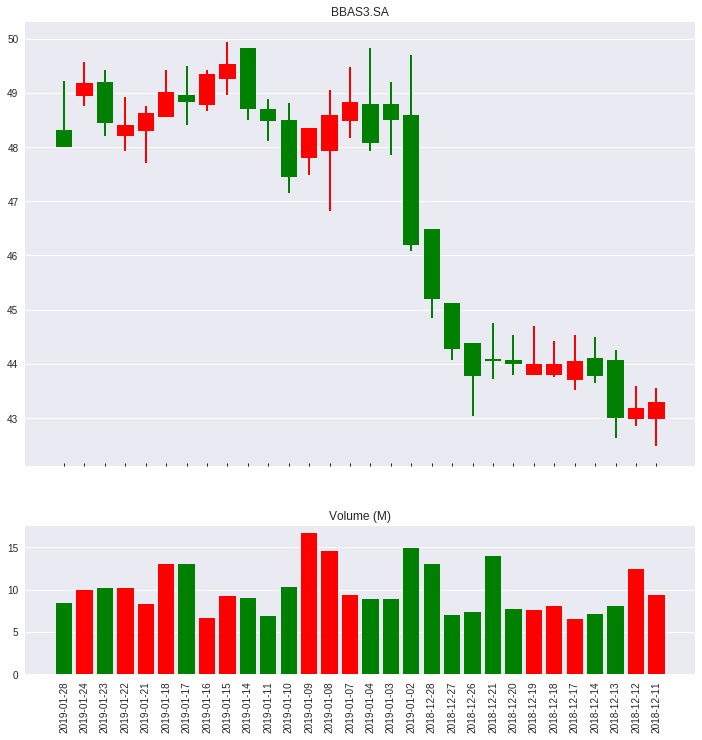

In [140]:
banksStockList.plot_candles_StockData('BBAS3.SA')

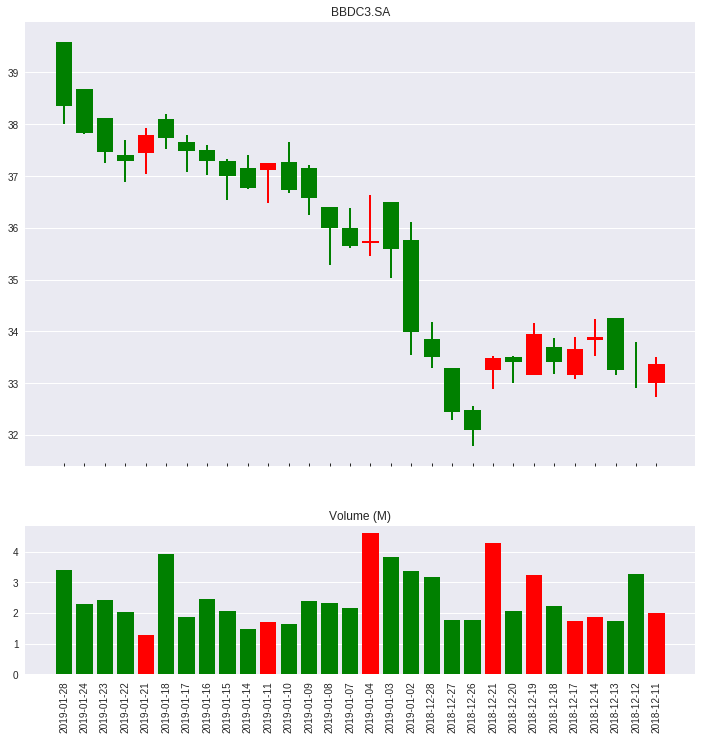

In [141]:
banksStockList.plot_candles_StockData('BBDC3.SA')

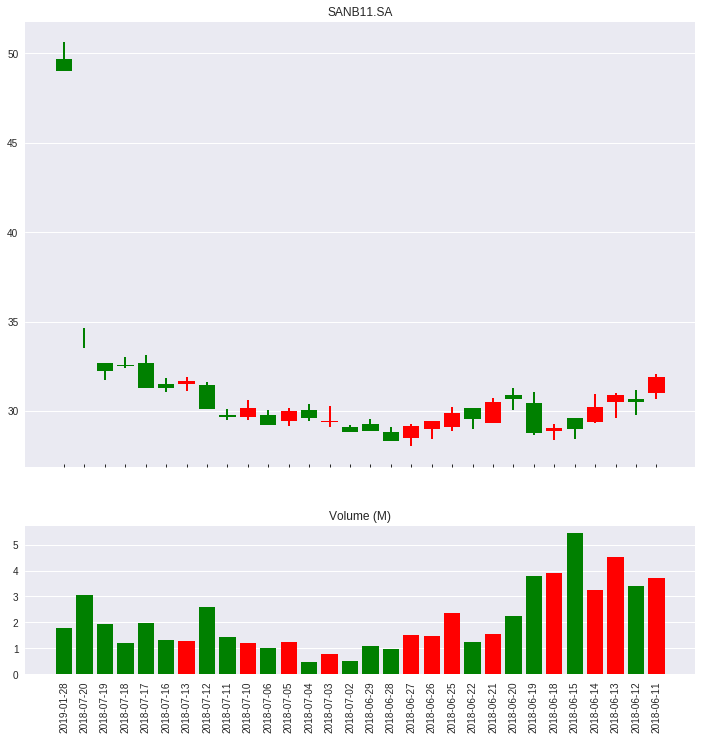

In [142]:
banksStockList.plot_candles_StockData('SANB11.SA')